In [1]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler



model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('logs/ControlNet/controlnet_mlsd_fixed_prompt/checkpoints/epoch=83-step=29735.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)



/home/ubuntu/anaconda3/envs/control/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ubuntu/anaconda3/envs/control/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


logging improved.
ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim

In [2]:


def process(input_image, 
            prompt, 
            a_prompt='best quality, extremely detailed', 
            n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality',
            num_samples=1, 
            image_resolution=512, 
            ddim_steps=20, 
            guess_mode=False, 
            strength=1.0, 
            scale=9.0, 
            seed=12315124, 
            eta=0):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape
        

        control = torch.from_numpy(img).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)
        # print(samples, intermediates)
        # print(samples.shape, intermediates.shape)
        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return results, samples, intermediates


In [3]:
from zillow_mlsd_dataset import MyDataset
dataset = MyDataset()


In [4]:
sample = dataset[0]
input_image = sample['jpg']
control = sample['hint']
prompt = sample['txt']

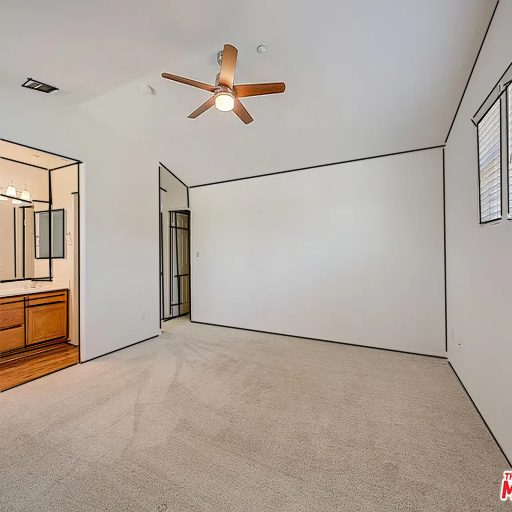

In [5]:
from PIL import Image
def target_to_pil(np_img):
    return Image.fromarray(np.uint8(127.5 * (np_img + 1)))
def source_to_pil(np_img):
    return Image.fromarray(np.uint8(255 * np_img))
source_to_pil(control)

In [6]:
sample['source_filename']

'source/1000_99_2.png'

In [23]:
import os
num_samples = 5
strengths = [2.0, 3.0, 5.0]
guidances = [10, 15, 25]
experiment_name = "controlnet_mlsd_fixed_prompt"
experiment_path = os.path.join("logs/ControlNet/", experiment_name)
outdir = os.path.join(experiment_path, "test")
os.makedirs(outdir, exist_ok=True)


In [24]:
import os
def get_step_from_filename(filename):
    parts = filename.split('.')
    step_part = parts[0].split('-')[-1]  # extract the part containing the step number
    step = int(step_part.split('=')[-1])
    return step


chkpt_dir = f"logs/ControlNet/{experiment_name}/checkpoints/"
chkpts = os.listdir(chkpt_dir)
ckpt_steps = list(map(get_step_from_filename, chkpts))
print(f'found {len(chkpts)} checkpoints for experiment {experiment_name} (min step: {min(ckpt_steps)}, max step: {max(ckpt_steps)})')



found 1 checkpoints for experiment controlnet_mlsd_fixed_prompt (min step: 29735, max step: 29735)


In [26]:
i = 0
for ckpt_fname in chkpts:
    ckpt_fpath = os.path.join(chkpt_dir, ckpt_fname)
    step_num = get_step_from_filename(ckpt_fname)
    
    for sample in dataset:
        expected_result = sample['jpg']
        control = sample['hint']
        prompt = sample['txt']
        fname = sample['source_filename'].replace('source/', '').replace('.png', '')
        source_to_pil(control).save(os.path.join(outdir, f'{i}.png'))
        for strength in strengths:
            for guidance in guidances:

                results, samples, intermediates = process(
                    np.uint8(255 * control), 
                    'a high-quality, detailed, and professional image of a furnished room',
                    strength=strength,
                    scale=guidance,
                    ddim_steps=20)

                result = Image.fromarray(results[0])
                result.save(os.path.join(outdir, f'{i}_strh{strength}_gs{guidance}_step{step_num}.png'))
        i += 1
        if i >= num_samples:
            break
            

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


In [ ]:
intermediates['x_inter'][2].shape

In [ ]:
Chan2RGB = [0,1,2]
# latents_np_seq = [tsr[0,Chan2RGB].permute(1,2,0).numpy() for tsr in latents_reservoir]

In [ ]:
tsr = intermediates['x_inter'][1].cpu()
intermediate_image_np = tsr[0,Chan2RGB].permute(1,2,0).numpy()

def normalize(x):
    return x / np.max(x)

target_to_pil(normalize(intermediate_image_np))

In [29]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
dtype = jnp.bfloat16
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="bf16",
    dtype=dtype,
)

ModuleNotFoundError: No module named 'flax'

In [28]:
!conda install jax

/bin/bash: conda: command not found
